<center><font size="14">Bloc n°1 - Construction et alimentation d'une infrastructure de gestion de données</center></font>

---



---

<font size="8">I) Travail préparatoire</font>

1.   Installation des packages nécessairs à la construction de l'infrastructure


In [1]:
!sudo add-apt-repository ppa:saiarcot895/chromium-beta
!sudo apt remove chromium-browser
!sudo snap remove chromium
!sudo apt install chromium-browser
!pip install selenium-stealth
!pip3 install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/saiarcot895/chromium-beta/ubuntu/ jammy main'
Description:
This PPA contains the latest Chromium Beta builds, with hardware video decoding enabled (hidden behind a flag), and support for Widevine (needed for viewing many DRM-protected videos) enabled.

== Hardware Video Decoding ==

To enable hardware video decoding, start Chromium with the --enable-features=VaapiVideoDecoder argument. To make this persistent, create a file at /etc/chromium-browser/customizations/92-vaapi-hardware-decoding with the following contents:

CHROMIUM_FLAGS="${CHROMIUM_FLAGS} --enable-features=VaapiVideoDecoder"

See also https://wiki.archlinux.org/title/Chromium#Hardware_video_acceleration for more information on VAAPI video decoding support.

=== Widevine Support ===

The packages in this PPA have support for Widevine inside Chromium enabled. However, you still need to copy some files from 

In [2]:
!pip install webdriver_manager

In [3]:
!pip install psycopg2


2.   Installation des bibliothèques nécéssaires à la construction de l'infrastructure



In [4]:
import os
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import psycopg2
from sqlalchemy import create_engine

In [5]:
#Install driver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

<font size="8">II) Construction du processus ETL</font>

Le processus ETL signifie l'Extraction, la Transformation et le Chargement de données. Le but ici est de collecter et traiter des données provenant du site ***infoclimat.fr*** pour ensuite les envoyer dans un espace de stockage temporaire (data lake) hébergé sur une base de données ElephantSQL (SGBD PostgreSQL) à des fins d'analyse et de traitement, par la suite, le traitement et le stockage définitif sera géré via le logiciel KNIME
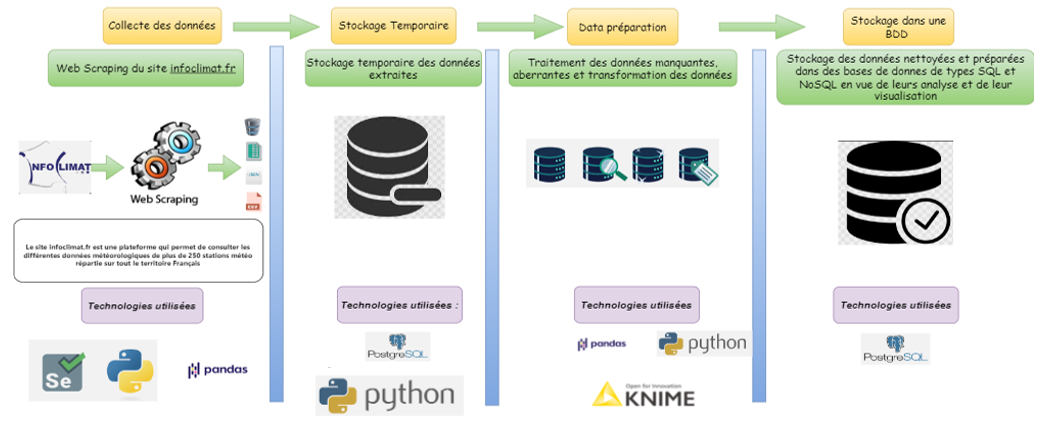

In [6]:
# Informations de connexion à la base de données PostgreSQL
host = 'mel.db.elephantsql.com'
database = 'jnjphmsd'
user = 'jnjphmsd'
password = '4btG68kuDpy3pLksVObr26ix5VhtMWjI'

# Création de la chaîne de connexion
connection_string = f'postgresql://{user}:{password}@{host}/{database}'

# Création de l'objet de connexion à la base de données PostgreSQL
engine = create_engine(connection_string)

# Liste Python contenant les valeurs à sélectionner
liste_valeurs = ['Abbeville (80)', 'Bordeaux-Mérignac (33)','Lille','Limoges','Paris','Nante','Lyon','Toulouse','Marseille','Strasbourg','Dunkerque','Perpignan','Orange',
                 'Rennes','Angers','Le Mans','Troyes','Nancy','Besançon','Clermont-Ferrand','Mont-de-Marsan','Dax-Seyresse','Poitiers','La Rochelle Aérodrome','Tours','Caen','Rouen','Le Havre','Saint-Etienne',
                 'Nîmes','Montpellier','Nouvion','Le Touquet', 'Le Bourget','Le Lamentin','Le breuil','Istres','Hyères','La Ciotat','La flegere','Agen','Toulon','Ajaccio','Porto-Vecchio']
# Utilisation de range pour créer une liste d'années de 1990 à 2023
liste_annee = list(range(1980, 2023))



###########################################################################  EXTRACTION DES DONNEES ######################################################################################


# Chemin vers le fichier HTML contenant la liste
url = 'https://www.infoclimat.fr/climatologie/annee/2022/limoges-bellegarde/valeurs/07434.html'

# Envoyer une requête GET pour récupérer le contenu HTML de la page
response = requests.get(url)
html_content = response.content

driver.get(url)
time.sleep(2)
test1 = driver.find_element(By.XPATH, '/html/body/div[6]/div[4]/div/div[2]/div/div[1]/h1/span[2]').text
print(test1)

# Parcourir les valeurs de la liste et les saisir dans la boîte de recherche
for valeur in liste_valeurs:

    # Identifier l'élément de la boîte de recherche
    search_city_box = driver.find_element(By.XPATH, '/html/body/div[6]/div[4]/div/div[1]/form/div[2]/a/span[1]')
    time.sleep(1)
    #
    search_city_box.click()

    # Attendre que la boîte de recherche déroulante soit visible
    wait = WebDriverWait(driver, 5)
    search_box_dropdown = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#select2-drop input.select2-input')))

    # Saisir la valeur dans la boîte de recherche déroulante
    search_box_dropdown.send_keys(valeur)
    time.sleep(1)
    # Appuyer sur la touche "Entrée" pour soumettre la recherche
    search_box_dropdown.send_keys(Keys.RETURN)
    time.sleep(3)

    #print(test2)

    for annee in liste_annee :
        # Identifier l'élément de la boîte de recherche
        search_annee_city = driver.find_element(By.XPATH, '/html/body/div[6]/div[4]/div/div[1]/form/div[1]/a/span[1]')
        time.sleep(3)
        search_annee_city.click()

        # Attendre que la boîte de recherche déroulante soit visible
        wait = WebDriverWait(driver, 5)
        search_box_year_dropdown = wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#select2-drop input.select2-input')))

        # Saisir la valeur dans la boîte de recherche déroulante
        print(annee)
        search_box_year_dropdown.send_keys(annee)
        time.sleep(1)
       # Appuyer sur la touche "Entrée" pour soumettre la recherche
        search_box_year_dropdown.send_keys(Keys.RETURN)
        time.sleep(3)

        table = driver.find_element(By.ID,'tableau-releves')  # Remplacez 'table_id' par l'ID réel de l'élément de tableau
        header_rows = table.find_elements(By.XPATH, './/tr[1]')  # Supposons que les en-têtes se trouvent dans la première ligne
        headers=[]
        for header_row in header_rows:
            header_cells = header_row.find_elements(By.TAG_NAME, 'th')  # Extraction des entêtes du tableau tableau
            for header_cell in header_cells:
                headers.append(header_cell.text)
                headers_table = [re.sub(r'\n|\.\n', ' ', item) for item in headers] # remplacent des caractères spéciaux pour la mise en forme
        headers = [element for element in headers if element != ""]
        headers = [item.replace('.\n', ' ') for item in headers]
        headers = [item.replace('\n', ' ') for item in headers]
        print(headers)
        #print(headers_table)

        data=[]
        rows_tables = table.find_elements(By.XPATH, './/tr')[1:]# extraction des lignes du tableau
        for rows_table in rows_tables:
            rows=[]
            rows_cells = rows_table.find_elements(By.TAG_NAME, 'td')
            for rows_cell in rows_cells:
              # Obtenir le contenu brut de la cellule
                cell_content = rows_cell.get_attribute('innerHTML')

                # Supprimer les balises <a> et <br> et leur contenu
                cell_content = re.sub(r'<a[^>]*>.*?</a>', '', cell_content)
                cell_content = re.sub(r'<br\s?/?>', '', cell_content)

                # Extraire le texte restant
                cell_text = re.sub(r'<.*?>', '', cell_content)
                cell_text = re.sub(r'&nbsp;', '', cell_text)

                # Ajouter le contenu nettoyé à la liste
                rows.append(cell_text.strip())
                #for a in rows_cell.find_elements(By.TAG_NAME, 'a'):
                    #driver.execute_script("arguments[0].remove()", a)
                    #rows.append(rows_cell.text)
            data.append(rows)
            #print(data)
        #df = pd.DataFrame(data, columns = headers_table)
        df = pd.DataFrame(data)
        #display(df)

        # Transposer le dataframe
        df_transposed = df.transpose()

        # Définir la première ligne comme les noms des colonnes
        df_transposed = df_transposed.set_axis(df_transposed.iloc[0], axis='columns', copy=False)
        df_transposed = df_transposed[1:]
        #display(df_transposed)

        ###########################################################################  TRANSFORMATION DES DONNEES ######################################################################################

        liste_contenu = []
        descritpion = driver.find_element(By.ID,'header-table-station')
        balises_li = descritpion.find_elements(By.TAG_NAME, 'li')
        for balise_li in balises_li:
            contenu = balise_li.text.replace('Fuseau horaire', '')
            contenu = balise_li.text.replace('Département ', '').replace('Altitude', '').replace('Coordonnées', '').replace('Début des archives', '').replace('Type de station', '')
            liste_contenu.append(contenu)
        balises_h1 = descritpion.find_elements(By.TAG_NAME, 'h1')
        for balise_h1 in balises_h1:
            contenu1 = balise_h1.text.replace('Station météorologique de','').replace('\n','').replace('Indicatif','')
            liste_contenu.append(contenu1)
            # Supprimer les éléments vides de la liste
            liste_contenu = [element for element in liste_contenu if element != ""]
        print(liste_contenu)

        # Ajout de nouvelles colonnes au dataframe
        df_transposed['Département'] = liste_contenu[0]
        df_transposed['Altitude'] = liste_contenu[1]
        df_transposed['Coordonnées'] = liste_contenu[2]
        df_transposed['Début des archives'] = liste_contenu[3]
        df_transposed['Type de station'] = liste_contenu[5]
        df_transposed['Station'] = liste_contenu[6]
        df_transposed['Mois'] = headers
        df_transposed[['Nom station','Num station']] = df_transposed['Station'].str.split(':',expand=True)
        df_transposed.drop('Station', axis=1, inplace=True)
        # Suppression des colonnes
        colonnes_a_supprimer = [5, 11, 18]
        df_transposed = df_transposed.drop(df_transposed.columns[colonnes_a_supprimer], axis=1)

###########################################################################  CHARGEMENT DES DONNES DANS UNE BASE DE DONNEES TEMPORAIRE ######################################################################################


        # Injection des données dans la table 'test' de la base de données PostgreSQL
        table_name = 'meteo_data'
        df_transposed.to_sql(table_name, engine, if_exists='append', index=False)
        #display(df_transposed.head(8))


# Fermeture du navigateur
driver.quit()

# Fermeture de la connexion à la base de données
engine.dispose()

Indicatif : 07434
1980
['janv 1980', 'fev 1980', 'mars 1980', 'avr 1980', 'mai 1980', 'juin 1980', 'juil 1980', 'août 1980', 'sept 1980', 'oct 1980', 'nov 1980', 'dec 1980', 'Année complète']
['80 Somme', ' 70 mètres', ' 50,13°N | 1,84°E', ' 4 octobre 1926', 'Fuseau horaire', ' METAR/SYNOP', 'Abbeville : 07005']
1981
['janv 1981', 'fev 1981', 'mars 1981', 'avr 1981', 'mai 1981', 'juin 1981', 'juil 1981', 'août 1981', 'sept 1981', 'oct 1981', 'nov 1981', 'dec 1981', 'Année complète']
['80 Somme', ' 70 mètres', ' 50,13°N | 1,84°E', ' 4 octobre 1926', 'Fuseau horaire', ' METAR/SYNOP', 'Abbeville : 07005']
1982
['janv 1982', 'fev 1982', 'mars 1982', 'avr 1982', 'mai 1982', 'juin 1982', 'juil 1982', 'août 1982', 'sept 1982', 'oct 1982', 'nov 1982', 'dec 1982', 'Année complète']
['80 Somme', ' 70 mètres', ' 50,13°N | 1,84°E', ' 4 octobre 1926', 'Fuseau horaire', ' METAR/SYNOP', 'Abbeville : 07005']
1983
['janv 1983', 'fev 1983', 'mars 1983', 'avr 1983', 'mai 1983', 'juin 1983', 'juil 1983', 

KeyboardInterrupt: ignored